# 0 - Test for GPU
Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats

import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Wed Jan 26 16:32:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    59W / 149W |    145MiB / 11441MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# 1 - Explore and preprocess the data
## 1.1 - Download and plot the data
We'll start by downloading our data set contained in a zip archive. Execute the code below for downloading and extracting the data to /tmp/bee-vs-wasp.zip.

In [2]:
#@title Data set download and preprocessing

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

dataset_file = '/tmp/kaggle_bee_vs_wasp.zip'
download_file_from_google_drive('1-aqpfT73D7HCQGoQEFg-phd3Mtsb9PiP',dataset_file)
unzip('/tmp/kaggle_bee_vs_wasp.zip')

The base directory `/tmp/bee-vs-wasp` contains the subdirectories. Let's define the base directory:

In [3]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

base_dir = '/tmp/kaggle_bee_vs_wasp/'

Get the `labels.csv` of the Dataset:

In [4]:
df = pd.read_csv(base_dir+'/labels.csv')
df = df.set_index('id')

# You can perform dataset subsampling by adding frac=training_subsample as argument to the sample function, 
# with training_subsample within [0,1].
# For development, you should use a small fraction of the entire dataset rater than full dataset, e.g. 0.1.
# For now lets use the whole Dataset
training_subsample = 1 
df = df.sample(frac=training_subsample,axis=0)


# Replace \\ in path with / to load images properly
for index in tqdm(df.index):    
    df.loc[index,'path']=df.loc[index,'path'].replace('\\', '/') 
df['path'] = base_dir + df['path']

100%|██████████| 11420/11420 [00:09<00:00, 1167.28it/s]


Let's take a look at how the `labels.csv` for our data set are structured:



In [ ]:
df

,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
id,,,,,,,,,
6271,/tmp/kaggle_bee_vs_wasp/wasp2/G00319.jpg,0,1,0,0,0,0,1,wasp
8183,/tmp/kaggle_bee_vs_wasp/other_insect/136041971...,0,0,1,0,1,0,1,insect
9638,/tmp/kaggle_bee_vs_wasp/other_insect/425316638...,0,0,1,0,1,0,0,insect
6126,/tmp/kaggle_bee_vs_wasp/wasp2/G00174.jpg,0,1,0,0,0,1,0,wasp
541,/tmp/kaggle_bee_vs_wasp/bee1/23468968398_6e157...,1,0,0,0,1,0,0,bee
...,...,...,...,...,...,...,...,...,...
4516,/tmp/kaggle_bee_vs_wasp/wasp1/46435313152_0b65...,0,1,0,0,1,0,0,wasp
6804,/tmp/kaggle_bee_vs_wasp/wasp2/I00063.jpg,0,1,0,0,0,0,0,wasp
6125,/tmp/kaggle_bee_vs_wasp/wasp2/G00173.jpg,0,1,0,0,0,0,1,wasp



Now we can create the training, validation and test data set by filtering the dataframe:

In [5]:
# Firstly, we create our training set from the data frame
train_df = df.query("(is_validation==0) and (is_final_validation==0)")
train_classes = train_df["label"]

# Now we can do the same for the valdation set
validation_df = df.query("(is_validation==1) and (is_final_validation==0)")
validation_classes = validation_df["label"]

# Now we can do the same for the test set
test_df = df.query("(is_validation==0) and (is_final_validation==1)")

And now print some statistics:

In [ ]:
assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)


for class_ in classes:
  print('Class {}: training images: {}, validation images: {}, test images: {}'.format(class_, train_df[train_df["label"]==class_].count()["label"], validation_df[validation_df["label"]==class_].count()["label"],test_df[test_df["label"]==class_].count()["label"]))

print('\nTotal training images:', len(train_df))
print('Total validation images:', len(validation_df))
print('Total test images:', len(test_df))
print('Number of classes:', num_classes)

Class insect: training images: 1706, validation images: 357, test images: 376
Class wasp: training images: 3439, validation images: 750, test images: 753
Class bee: training images: 2195, validation images: 484, test images: 504
Class other: training images: 598, validation images: 128, test images: 130

Total training images: 7938
Total validation images: 1719
Total test images: 1763
Number of classes: 4


And now we plot some examples of the test data set:

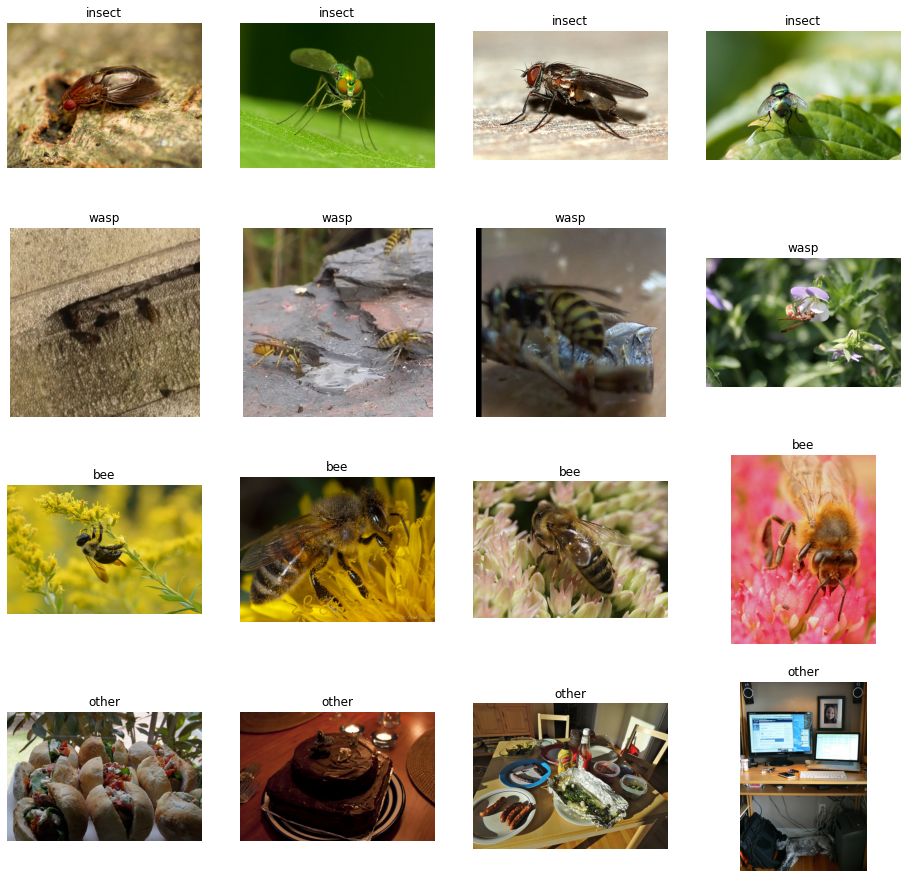

In [ ]:
#@title Plot images

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(train_df["path"], train_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.title(class_)
    plt.imshow(img)
    
plt.show()

Now we create our data set generators as learned in the lecture:

In [6]:
#@title Prepare data generators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(
                    train_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True,
                    seed=42)

num_classes = 4

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_dataframe(
                    validation_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=False)

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_dataframe(
                    test_df,
                    x_col="path",
                    y_col="label",
                    target_size=(224,224),
                    class_mode='categorical',
                    shuffle=False)

train_steps = np.ceil(train_generator.samples / train_generator.batch_size)
val_steps = np.ceil(validation_generator.samples / validation_generator.batch_size)

print(train_steps)
print(val_steps)

Found 7938 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.
125.0
27.0


# 2 - Train ResNet50 with transfer learning

We now build and train the model. For now lets use a fresh `ResNet50` model trained with transfer learning.

In [7]:
#@title Build the ResNet50 model

from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# ResNet50 top only includes 
# avg_pool  (GlobalAveragePooling2D)  (None, 2048)    0   ['conv5_block3_out[0][0]']       
# predictions (Dense)   (None, 1000)    2049000   ['avg_pool[0][0]']  

def build_model(input_shape, num_classes, summary=True):

  pre_trained_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

  x = layers.GlobalAveragePooling2D()(pre_trained_model.output)
  output = layers.Dense(num_classes, activation = 'softmax')(x)

  # define the model
  model = Model(pre_trained_model.input, output, name='res_net_model')

  return model, pre_trained_model

model, pre_trained_model = build_model((224,224,3), 4)
pre_trained_model.trainable = False
print(model.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model: "res_net_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

Now we define our initial learning rate for the training and define our model:

In [8]:
#@title Compile the model

INITIAL_LEARNING_RATE = 1e-3
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=INITIAL_LEARNING_RATE), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


----------------------------------------- THIS SECTION IS FOR TRAINING THE RESNET (SKIP IF YOU ALREADY TRAINED WEIGHTS) ------------------------------

In this section we train our network with the methods learned in the lecture:

In [ ]:
#@title Plot the training history

from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

In [ ]:
#@title LRD and early stopping

def lr_step_decay(epoch, lr, drop=.9, drop_epochs=10):
  if epoch < 10:
    return INITIAL_LEARNING_RATE
  else:
    return INITIAL_LEARNING_RATE * np.power(drop, np.floor(epoch/drop_epochs))

LRDecayCallback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)
StopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)


Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
125/125 - 177s - loss: 1.2664 - accuracy: 0.4184 - val_loss: 1.2563 - val_accuracy: 0.4363 - lr: 0.0010 - 177s/epoch - 1s/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/200
125/125 - 162s - loss: 1.2241 - accuracy: 0.4349 - val_loss: 1.2006 - val_accuracy: 0.4450 - lr: 0.0010 - 162s/epoch - 1s/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/200
125/125 - 160s - loss: 1.2133 - accuracy: 0.4365 - val_loss: 1.1873 - val_accuracy: 0.4340 - lr: 0.0010 - 160s/epoch - 1s/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/200
125/125 - 154s - loss: 1.1993 - accuracy: 0.4414 - val_loss: 1.1683 - val_accuracy: 0.4380 - lr: 0.0010 - 154s/epoch - 1s/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/200
125/125 - 153s - loss: 1.1921 - accuracy: 0.4442 - val_loss: 1.1745 - val_accuracy: 0.4933 -

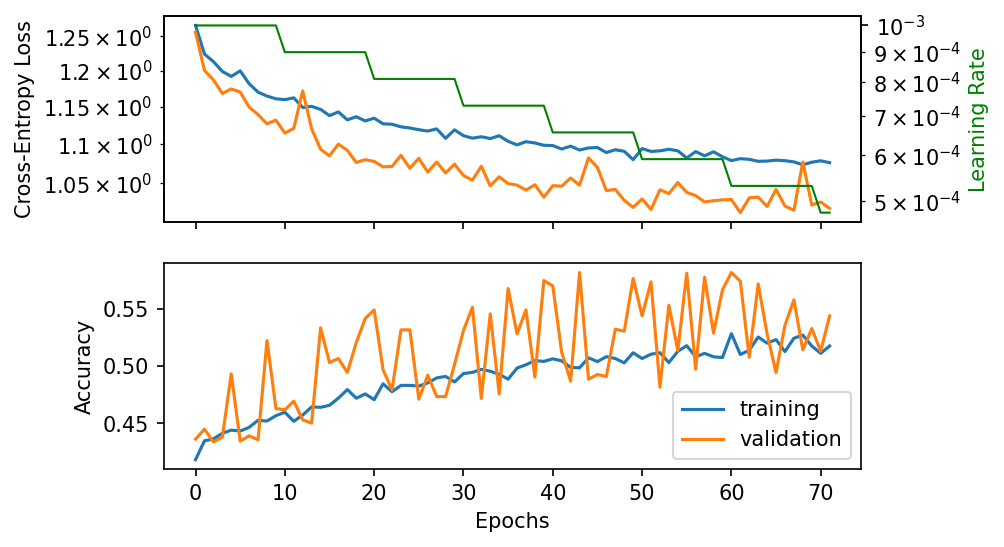

In [ ]:
#@title Train the model (frozen)

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=200,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[LRDecayCallback,StopCallback],
                    verbose=2)

plot_history(history)

The learned weights should be saved so we can use them again:

In [ ]:
#@title Save the intermediate weights

from google.colab import drive
drive.mount('/content/gdrive')
name_of_trained_weights = 'resnet_weights_pre'
model.save_weights('/tmp/'+ name_of_trained_weights)

%cp /tmp/resnet_weights_pre.data-00000-of-00001 /content/gdrive/My\ Drive
%cp /tmp/resnet_weights_pre.index /content/gdrive/My\ Drive

Mounted at /content/gdrive


To increase the accuracy, you can also fine-tune the weights of the pre-trained network for learning more discriminant representations of your data. All you need to to is unfreeze the layers of the pre-trained network. 

In [ ]:
#@title Unfreeze model

INITIAL_LEARNING_RATE = 3e-5

pre_trained_model.trainable = True
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=INITIAL_LEARNING_RATE), metrics=['accuracy'])

print(model.summary())

Model: "res_net_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Now, continue to train the model for a maximum of 200 epochs.


Epoch 00001: LearningRateScheduler setting learning rate to 3e-05.
Epoch 1/200
125/125 - 217s - loss: 4.9211 - accuracy: 0.7411 - val_loss: 11.9679 - val_accuracy: 0.4363 - lr: 3.0000e-05 - 217s/epoch - 2s/step

Epoch 00002: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/200
125/125 - 199s - loss: 0.5735 - accuracy: 0.8720 - val_loss: 8.9923 - val_accuracy: 0.4363 - lr: 3.0000e-05 - 199s/epoch - 2s/step

Epoch 00003: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/200
125/125 - 197s - loss: 0.4115 - accuracy: 0.8879 - val_loss: 9.0963 - val_accuracy: 0.4380 - lr: 3.0000e-05 - 197s/epoch - 2s/step

Epoch 00004: LearningRateScheduler setting learning rate to 3e-05.
Epoch 4/200
125/125 - 205s - loss: 0.3298 - accuracy: 0.9010 - val_loss: 7.0617 - val_accuracy: 0.4654 - lr: 3.0000e-05 - 205s/epoch - 2s/step

Epoch 00005: LearningRateScheduler setting learning rate to 3e-05.
Epoch 5/200
125/125 - 205s - loss: 0.2770 - accuracy: 0.9109 - val_loss: 4.1515 - val_a

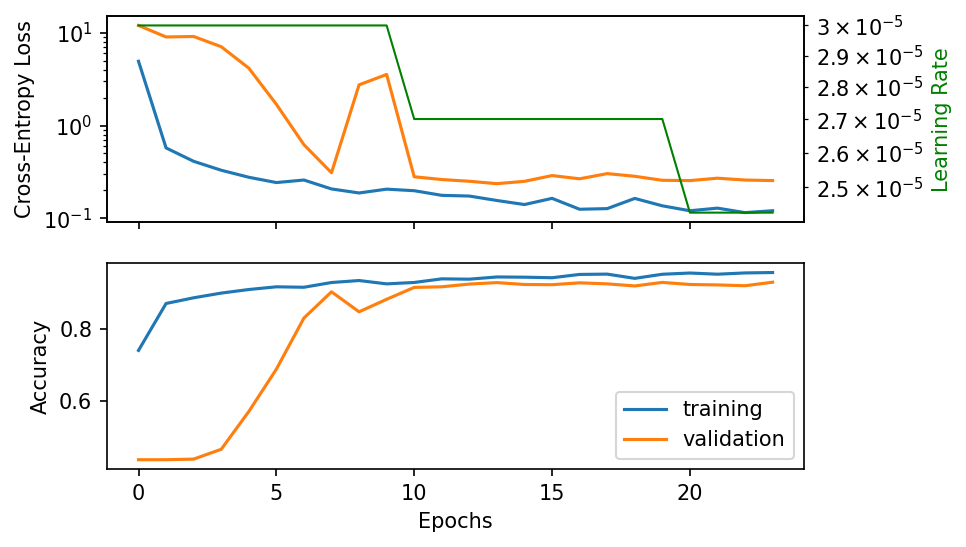

In [ ]:
#@title Train the model

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=200,
                    validation_data=validation_generator,
                    validation_steps=val_steps,
                    callbacks=[LRDecayCallback, StopCallback],
                    verbose=2,
                    )

plot_history( history )

Save the weights of the finished transfer learning.

In [ ]:
#@title Save the final weights

from google.colab import drive
drive.mount('/content/gdrive')
name_of_trained_weights = 'resnet_weights_pre_finished'
model.save_weights('/tmp/'+ name_of_trained_weights)

%cp /tmp/resnet_weights_pre_finished.data-00000-of-00001 /content/gdrive/My\ Drive
%cp /tmp/resnet_weights_pre_finished.index /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---------------------------------------------- END OF TRAINING SECTION ----------------------------------------------------

# 3 - Training results

Here you can load already trained weights to the defined model:

In [9]:
#@title Load the trained weights

from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/gdrive/My\ Drive/resnet_weights_pre_finished.data-00000-of-00001 /tmp/
%cp /content/gdrive/My\ Drive/resnet_weights_pre_finished.index /tmp/
model.load_weights("/tmp/resnet_weights_pre_finished")

Mounted at /content/gdrive


Now lets take a look at the results:

In [10]:
#@title Print training results and predictions

# We output the test accuracy and loss
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Use the model to predict the images of the test generator
pred = model.predict_generator(test_generator,  1763)

# And get their according labels
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_generator.class_indices)

# Swap indices with label for comparison
labels2=dict((v,k) for k,v in labels.items())

# Output the label as a human readable prediction 
predictions=[labels2[k] for k in predicted_class_indices]

print(predicted_class_indices)
print(labels)
print(predictions)


56/56 [==============================] - 36s 353ms/step - loss: 0.2601 - accuracy: 0.9291
test loss, test acc: [0.26013651490211487, 0.9290981292724609]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


[1 2 3 ... 3 3 3]
{'bee': 0, 'insect': 1, 'other': 2, 'wasp': 3}
['insect', 'other', 'wasp', 'bee', 'other', 'wasp', 'wasp', 'wasp', 'wasp', 'wasp', 'other', 'other', 'bee', 'insect', 'wasp', 'other', 'insect', 'bee', 'insect', 'wasp', 'wasp', 'bee', 'insect', 'bee', 'insect', 'bee', 'wasp', 'wasp', 'wasp', 'insect', 'other', 'wasp', 'wasp', 'wasp', 'insect', 'insect', 'bee', 'wasp', 'wasp', 'wasp', 'insect', 'wasp', 'wasp', 'other', 'other', 'wasp', 'wasp', 'bee', 'wasp', 'wasp', 'wasp', 'insect', 'insect', 'bee', 'wasp', 'wasp', 'bee', 'insect', 'other', 'bee', 'bee', 'wasp', 'wasp', 'wasp', 'bee', 'wasp', 'bee', 'wasp', 'bee', 'bee', 'other', 'bee', 'insect', 'insect', 'wasp', 'insect', 'wasp', 'insect', 'bee', 'bee', 'wasp', 'bee', 'insect', 'bee', 'wasp', 'wasp', 'insect', 'bee', 'bee', 'wasp', 'wasp', 'wasp', 'bee', 'wasp', 'insect', 'insect', 'bee', 'insect', 'wasp', 'insect', 'wasp', 'wasp', 'wasp', 'wasp', 'bee', 'wasp', 'insect', 'insect', 'other', 'insect', 'bee', 'wasp', 'b

Now we can print a confusion matrix to see how big the error of our trained model is:

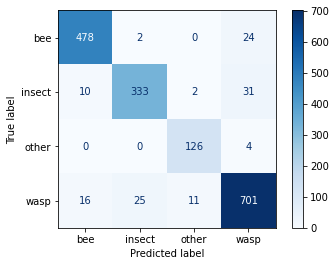

In [11]:
#@title Confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(test_df["label"],predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

Now that we have some metrics lets test our predictions on some images:

In [ ]:
#@title Plot results

def displayImagesLabelsAndPredictions(array_of_idx):
  plt.figure(figsize=(15,10))
  pos = 1
  idx = 0
  for row in np.array(test_df['path'])[array_of_idx]:
    img = cv2.imread(row)

    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title("label: "+str((np.array(test_df["label"])[array_of_idx][idx])+"\n prediction: "+str(np.array(predictions)[array_of_idx][idx])))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    #Remove ticks
    plt.xticks([])
    plt.yticks([])
    pos+=1
    idx+=1
  plt.show()

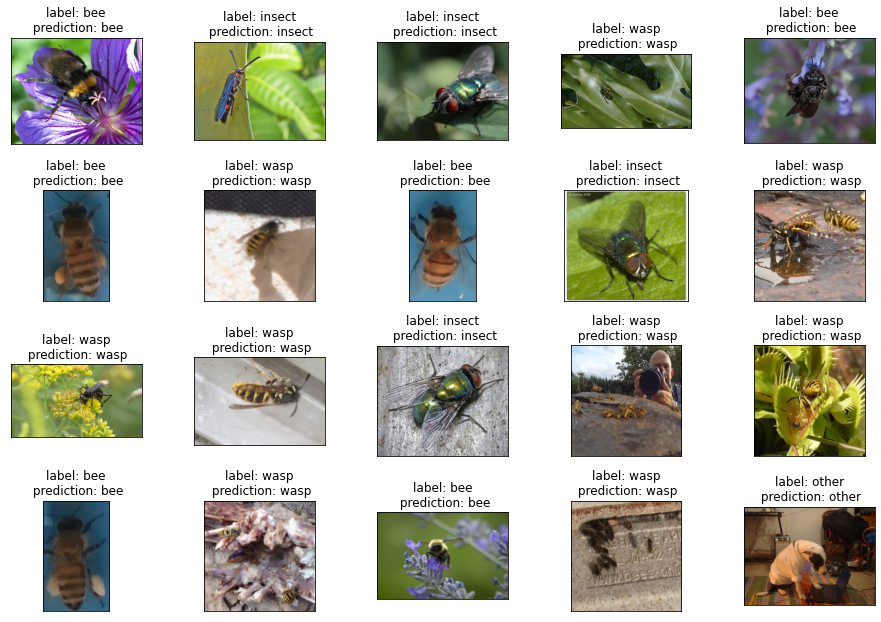

In [ ]:
import random
img_count=20
random_images = random.sample(range(1763), img_count)
displayImagesLabelsAndPredictions(random_images)